# Illustration of loading GTC_FPSDP output files  

This example will show how to use `FPSDP` package to load and exam GTC output files

## 1. Importing the GTC_Loader module 

`GTC_Loader` module is located at `FPSDP.Plasma.GTC_Profile` package, in addition to the main `GTC_Loader` class, some other useful modules are loaded, so can be accessed via this module. e.g. `FPSDP.Geometry.Grid.Cartesian2D` can be used to create 2D Cartesian grids. The following import statement will fetch `GTC_Loader` module and name it `gtc`.

In [4]:
import FPSDP.Plasma.GTC_Profile.GTC_Loader as gtc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Define relevant quantities

Before loading GTC output files, it is convenient to define some quantities for initialization. They are:

1.The directory that contains all GTC output files

In [5]:
gtc_path = 'Data/GTC_Outputs/oct25/'

2.The grid on which all data will be interpolated or extrapolated. 


For now, only `Cartesian2D` grids are accepted. `Cartesian2D` grids can be generated by giving __*DownLeft*__ and __*UpRight*__ coordinates (Z,R) of the box (in meter), and __*NR*__ and __*NZ*__ of grid points, or __*ResR*__ and __*ResZ*__ as the resolution on each direction (in meter). For our GTC run, let's make a box that's larger than the simulation domain:

In [6]:
grid2d = gtc.Cartesian2D(DownLeft = (-0.6,0.6), UpRight = (0.6,1.2), ResR = 0.01, ResZ = 0.01)

3.The time steps we are interested in 

Valid time steps are the integer number in "*snapXXXXXXX_fpsdp.json*" file names. We should provide a list of integer to `GTC_Loader`, if any of the time steps are not available, an exception will be raised along with the valid time steps information. We'll see the example later.

In [7]:
timesteps = [1,2,3]

## 3. Load data files 

Now, we are ready to load the output files:

In [8]:
gtcdata = gtc.GTC_Loader(gtc_path,grid2d,timesteps)

2D grid detected.
Time 3 not available!
Available time steps are:
[1 2]


GTC_Loader_Error: ('Time 3 not available!', array([1, 2]))

As we can see, first, our 2D grid are detected and accepted. Then, an error occurs. Since our output files only contain time steps 1 and 2, when we try to aquire time 3, our Loader will complain and tell us only `[1,2]` are available. Let's try again:

In [12]:
timesteps = [1,2]
gtcdata = gtc.GTC_Loader(gtc_path,grid2d,timesteps)

2D grid detected.
All time available.


This time, all went well. Now, gtcdata is ready, we can then take a look at it's content. 

## 4. Exam data

Python objects use `__dict__` to store all attributes, we can use it's `keys()` method to list all the attribute names. 

In [13]:
gtcdata.__dict__.keys()

['B_Z_interp',
 'a_eq_interp',
 'trifinder_gtc',
 'a_1D',
 'Bphi_on_grid',
 'BR_on_grid',
 'Te0_on_grid',
 'ne0_1D',
 'Te0_interp',
 'dimension',
 'B_R_interp',
 'ne0_on_grid',
 'isEM',
 'phi_on_grid',
 'R_gtc',
 'B_phi',
 'B_phi_interp',
 'Te0_1D',
 'theta_gtc',
 'time_all',
 'Z0',
 'Delaunay_eq',
 'a_gtc',
 'phi',
 'a_on_grid',
 'R0',
 'a_eq',
 'Delaunay_gtc',
 'trifinder_eq',
 'ne0_interp',
 'B_Z',
 'grid',
 'triangulation_eq',
 'points_eq',
 'path',
 'B_R',
 'BZ_on_grid',
 'HaveElectron',
 'triangulation_gtc',
 'snapstep',
 'R_eq',
 'B0',
 'psi1',
 'Z_eq',
 'tsteps',
 'points_gtc',
 'Z_gtc']

That's a LOT of stuff... Fortunately, only some of them are supposed to be used directly. Let me introduce them one by one. 

#### 1.GTC run parameters 

Some relevant GTC run parameters are determined by data in gtc.in.out and gtc.out files. They are: isEM, HaveElectron **(MORE IS TO BE ADDED)**

`isEM` is a boolean flag showing if the GTC run has **electromagnetic perturbations**.

In [14]:
gtcdata.isEM

True

It's shown that our GTC run here has electromagnetic perturbations.

`HaveElectron` is a boolean flag showing if the GTC run has **non-adiabatic electrons**.

In [15]:
gtcdata.HaveElectron

False

Our GTC run apparently doesn't include non-adiabatic electrons

#### 2.Raw data got from GTC output files

Second kind of attributes store the raw data read from GTC output files. They are normally named after their data entry names in the output files. They are: **`R_gtc`, `Z_gtc`, `a_gtc`, `R_eq`, `Z_eq`, `a_eq`, `B_phi`, `B_R`, `B_Z`**, and **`phi`**.

`R_gtc`, `Z_gtc` are R,Z coordinates for each mesh grid point in GTC simulation. `a_gtc` is the radial flux coordinate on this mesh. In our case, it's the poloidal magnetic flux $\psi_p$. `theta_gtc` is the poloidal flux coordinate $\theta$ on the same mesh. Let's take a look at them: 

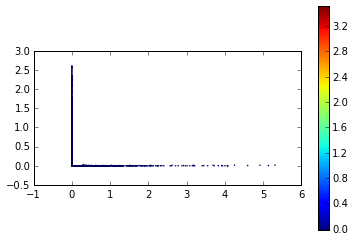

In [16]:
fig=plt.figure()
plt.scatter(gtcdata.R_gtc, gtcdata.Z_gtc, s=2, c=gtcdata.a_gtc, linewidth = 0.1)
plt.colorbar()
fig.axes[0].set_aspect(1)

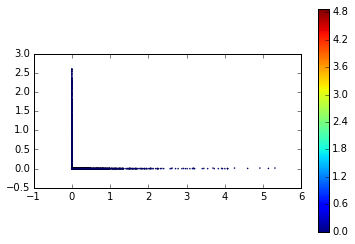

In [17]:
fig = plt.figure()
plt.scatter(gtcdata.R_gtc, gtcdata.Z_gtc, s=2, c=gtcdata.theta_gtc, linewidth = 0.1)
plt.colorbar()
fig.axes[0].set_aspect(1)

It is clear that $\psi_p$ is not normalized, and $\theta$ is defined between $[0,2\pi)$

`R_eq`, `Z_eq` and `a_eq` have similar physical meaning as their `_gtc` counter parts. The difference is that, by definition, they should cover the whole poloidal cross-section, from magnetic axis to the outmost closed flux surface, while `_gtc` quantities only cover GTC simulation region which usually excludes the magnetic axis and edge region. These `_eq` quantities are used to interpolate all equilibrium profiles and magnetic field. While equilibrium electron density and temperature are functions of $\psi_p$ only, i.e. $n_e(\psi_p)$ and $T_e(\psi_p)$, equilibrium magnetic field is a vector field on the whole poloidal cross-section. We use `B_phi`, `B_R` and `B_Z` to store the 3 components of the equilibrium magnetic field. Let's take a look at them: **(ISSUE #1 NEEDS TO BE RESOLVED)**

ValueError: Color array must be two-dimensional

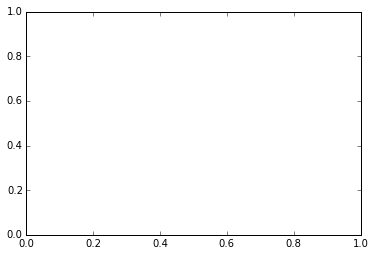

In [18]:
fig = plt.figure()
plt.scatter(gtcdata.R_eq,gtcdata.Z_eq, s=2, c= gtcdata.B_phi, linewidth = 0.1)
plt.colorbar()
fig.axes[0].set_aspect(1)

In [ ]:
fig = plt.figure()
plt.scatter(gtcdata.R_eq,gtcdata.Z_eq, s=2, c= gtcdata.B_R, linewidth = 0.1)
plt.colorbar()
fig.axes[0].set_aspect(1)

In [ ]:
fig = plt.figure()
plt.scatter(gtcdata.R_eq,gtcdata.Z_eq, s=2, c= gtcdata.B_Z, linewidth = 0.1)
plt.colorbar()
fig.axes[0].set_aspect(1)

Finally, `phi` stores the perturbed potential at each requested time step. Let's see snapshot 1:

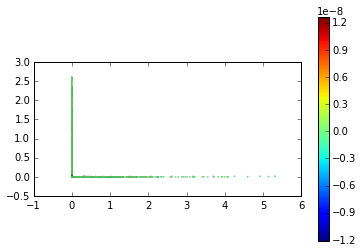

In [19]:
fig = plt.figure()
plt.scatter(gtcdata.R_gtc,gtcdata.Z_gtc, s=2, c= gtcdata.phi[0], linewidth = 0.1)
plt.colorbar()
fig.axes[0].set_aspect(1)

#### 3. 1D equilibrium profiles

As mentioned before, equilibrium density and temperature profiles are given as functions of $\psi_p$ only. These functions are specified by a $\psi_p$ array (`a_1D`) and corresponding $n_e$ (`ne0_1D`) and $T_e$ (`Te0_1D`) values. **(ISSUE #2 NEEDS TO BE RESOLVED)**

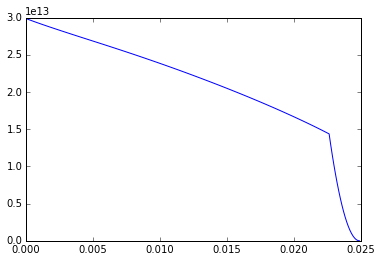

In [20]:
plt.plot(gtcdata.a_1D,gtcdata.ne0_1D)

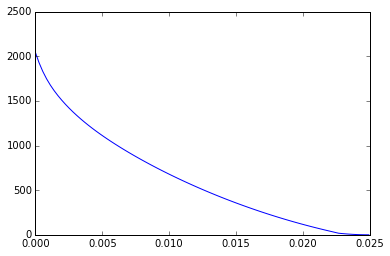

In [21]:
plt.plot(gtcdata.a_1D,gtcdata.Te0_1D)

#### 4. Interpolated and/or extrapolated data

All interpolated data are stored in `_on_grid` quantities. Let's look at them one by one:

$\psi_p$ (`a_on_grid`) is interpolated inside the convex hull of points given by `R_eq` and `Z_eq`, and linearly extrapolated outside based on the two partial derivatives on the boundary. 

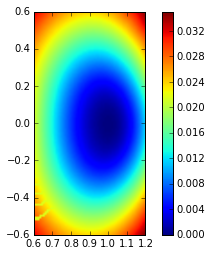

In [22]:
fig = plt.figure()
plt.imshow(gtcdata.a_on_grid, extent = [0.6,1.2,-0.6,0.6])
plt.colorbar()
fig.axes[0].set_aspect(1)

$n_{e0}$ and $T_{e0}$ are interpolated on $\psi_p$, and then applied to `a_on_grid` to obtain values on grid. **(ISSUE #2 NEEDS TO BE RESOLVED)**

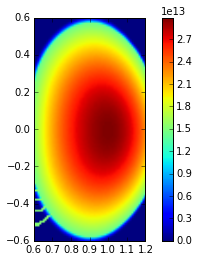

In [23]:
fig = plt.figure()
plt.imshow(gtcdata.ne0_on_grid, extent = [0.6,1.2,-0.6,0.6])
plt.colorbar()
fig.axes[0].set_aspect(1)

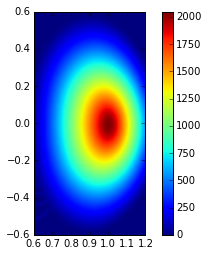

In [24]:
fig = plt.figure()
plt.imshow(gtcdata.Te0_on_grid, extent = [0.6,1.2,-0.6,0.6])
plt.colorbar()
fig.axes[0].set_aspect(1)

`Bphi_on_grid`, `BR_on_grid`, and `BZ_on_grid` are similarly interpolated and extrapolated. **(ISSUE #1 NEEDS TO BE RESOLVED)**

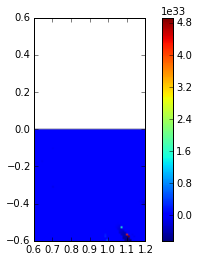

In [25]:
fig = plt.figure()
plt.imshow(gtcdata.Bphi_on_grid, extent = [0.6,1.2,-0.6,0.6])
plt.colorbar()
fig.axes[0].set_aspect(1)

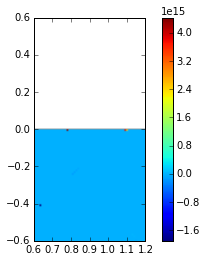

In [26]:
fig = plt.figure()
plt.imshow(gtcdata.BR_on_grid, extent = [0.6,1.2,-0.6,0.6])
plt.colorbar()
fig.axes[0].set_aspect(1)

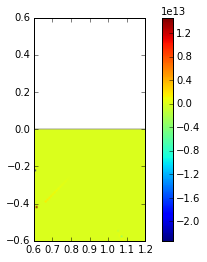

In [27]:
fig = plt.figure()
plt.imshow(gtcdata.BZ_on_grid, extent = [0.6,1.2,-0.6,0.6])
plt.colorbar()
fig.axes[0].set_aspect(1)

`phi` is interpolated on `R_gtc` and `Z_gtc`, but not extrapolated. All points outside the simulation grid are assigned 0 values.

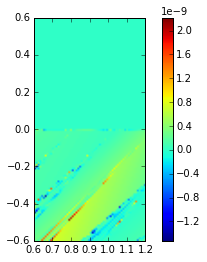

In [28]:
fig = plt.figure()
plt.imshow(gtcdata.phi_on_grid[0], extent = [0.6,1.2,-0.6,0.6])
plt.colorbar()
fig.axes[0].set_aspect(1)